## Imports, Classes, and Constants

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

RANDOM_SEED = 42

class StemCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemCountVectorizer, self).build_analyzer()
        
        return lambda document: ([SnowballStemmer('english', ignore_stopwords=True).stem(word) for word in analyzer(document)])

## Data Preprocessing

In [21]:
mcu_subset = pd.read_csv("./data/mcu_subset.csv")

np.random.seed(RANDOM_SEED)
mcu_subset = mcu_subset.reindex(np.random.permutation(mcu_subset.index))

mcu_subset.head()

,Unnamed: 0,character,line,movie,year,words,Adam McKay,Anna Boden,Art Marcum,Ashley Edward Miller,...,Joss Whedon,Justin Theroux,Mark Fergus,Matt Holloway,Paul Rudd,Ryan Coogler,Ryan Fleck,Shane Black,Stephen McFeely,Zack Stentz
3393,6565,STEVE ROGERS,"People are gonna die, Buck. I can't let that happen. Please, don't make me do this.",Captain America: The Winter Soldier,2014,17,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4909,11269,PETER PARKER,"Yeah, actually, I don’t intern for him anymore.",Spider-Man: Homecoming,2017,8,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4815,11073,PETER PARKER,Who are these guys? What can you tell me about the guy with the wings?,Spider-Man: Homecoming,2017,15,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3434,6641,STEVE ROGERS,You don't have to come with me.,Captain America: The Winter Soldier,2014,7,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
96,143,TONY STARK,"Finally, I want: three pairs of tube socks, white, a toothbrush, protein powder, spices, sugar, five pounds of tea, cards. And a washing machine. Top load.",Iron Man,2008,29,False,False,True,False,...,False,False,True,True,False,False,False,False,False,False


In [22]:
pd.DataFrame(mcu_subset['character'].value_counts())

,character
TONY STARK,1787
STEVE ROGERS,977
THOR,863
PETER PARKER,551
NATASHA ROMANOFF,498
PEPPER POTTS,441
BRUCE BANNER,379
NICK FURY,366
LOKI,327
JAMES RHODES,318


In [23]:
y = mcu_subset["character"].to_numpy().astype(str)
X = mcu_subset["line"].to_numpy().astype(str)

X[0:10], y[0:10]

(array(["People are gonna die, Buck. I can't let that happen.  Please, don't make me do this.",
        'Yeah, actually, I don’t intern for him anymore.',
        'Who are these guys? What can you tell me about the guy with the wings?',
        "You don't have to come with me.",
        'Finally, I want: three pairs of tube socks, white, a toothbrush, protein powder, spices, sugar, five pounds of tea, cards.  And a washing machine.  Top load. ',
        "We're not salvaging anything. We're not just taking down the carriers, Nick, we're taking down SHIELD.",
        'The September Foundation.', "Kid, that's the wizard. Get on it.",
        'Okay, Clint.  Starting in three, two, one...',
        "You know damn well! You know damn well who!  She wouldn't want us to fight."],
       dtype='<U1388'),
 array(['STEVE ROGERS', 'PETER PARKER', 'PETER PARKER', 'STEVE ROGERS',
        'TONY STARK', 'STEVE ROGERS', 'TONY STARK', 'TONY STARK',
        'BRUCE BANNER', 'THOR'], dtype='<U16'))

## Models

In [72]:
cross_validator = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
hyperparameter_cross_validator = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
score_method = "balanced_accuracy"

In [73]:
stem_count_vectorizer = StemCountVectorizer(binary=False)
tfidf_transformer = TfidfTransformer()
nb_classifier = MultinomialNB(alpha=0.01)

In [74]:
count_params = {'vect__stop_words': [None, stopwords.words('english')],
              'vect__ngram_range': [(1,1), (1,2)]}

tfidf_params = {'tfidf__use_idf': [True, False]}

nb_params = {'clf__fit_prior': [True, False]}

In [75]:
pipe13 = Pipeline([('vect', stem_count_vectorizer),
                  ('tfidf', tfidf_transformer),
                  ('clf', nb_classifier)])

parameters13 = {**count_params, **tfidf_params, **nb_params}

model13 = GridSearchCV(pipe13, parameters13, cv=hyperparameter_cross_validator, scoring=score_method, n_jobs=-1, verbose=6)

## Nested CV Balanced Accuracy

In [72]:
models = {"model 13": model13}

cv_score_table = pd.DataFrame()

for name, model in models.items():
    results = cross_val_score(model, X, y, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=6)
    cv_score_table.insert(len(cv_score_table.columns), name, results, True)

cv_score_table.index.name = "fold"
cv_score_table.loc["mean"] = cv_score_table.mean()
cv_score_table.loc["std"] = cv_score_table.std()
cv_score_table.loc["max"] = cv_score_table.max()

cv_score_table

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 32.0min remaining: 48.1min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 32.0min remaining: 21.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 32.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 32.5min finished


,model 13
fold,
0,0.274557
1,0.285970
2,0.269714
3,0.272935
4,0.288112
mean,0.278257
std,0.007370
max,0.288112


## Confusion Matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 33.6min remaining: 50.3min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 33.6min remaining: 22.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 34.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 34.0min finished


Balanced Accuracy: 0.2782638052929735
Balanced Accuracy: 0.27826380529297345


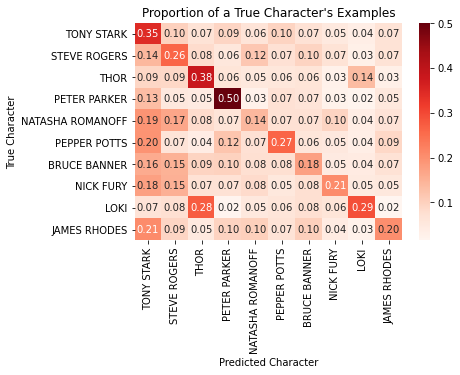

In [73]:
yhat = cross_val_predict(model13, X, y, cv=cross_validator, n_jobs=-1, verbose=6)

main_characters = mcu_subset['character'].value_counts().index.to_numpy()

conf_matrix = pd.DataFrame(metrics.confusion_matrix(y, yhat, labels=main_characters))
normalized_conf_matrix = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
normalized_conf_matrix.columns = pd.Series(main_characters, name="Predicted Character")
normalized_conf_matrix.index = pd.Series(main_characters, name="True Character")

plt.title("Proportion of a True Character's Examples")
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

# Should be the same
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y,yhat))
print("Balanced Accuracy:", np.mean(np.diagonal(normalized_conf_matrix)))

## Recalls

In [74]:
recalls = pd.DataFrame(np.diagonal(normalized_conf_matrix.to_numpy()), index=main_characters, columns=["recall"])
recalls.sort_values(by="recall", ascending=False, inplace=True)
recalls.loc['mean'] = recalls.mean()

recalls.to_csv("./front_end/production_recalls.csv")

recalls

,recall
PETER PARKER,0.500907
THOR,0.383546
TONY STARK,0.345831
LOKI,0.293578
PEPPER POTTS,0.265306
STEVE ROGERS,0.264074
NICK FURY,0.207650
JAMES RHODES,0.204403
BRUCE BANNER,0.176781
NATASHA ROMANOFF,0.140562


## Prediction Table

In [14]:
prediction_table = pd.DataFrame({"line": X, "true character": y, "predicted character": yhat, "movie": mcu_subset['movie']})

prediction_table.sort_index(inplace=True)

dump(prediction_table, "./front_end/production_predictions.joblib")

prediction_table.head()

,line,true character,predicted character,movie
0,Good sport. Have fun?,TONY STARK,LOKI,Avengers: Endgame
1,"This thing on? Hey, Ms. Potts. Pep. If you find this recording, don’t post it on social media. It’s going to be a real tearjerker. I don’t know if you’re ever going to see these. I don’t even know if you’re still...God, I hope so. Today’s day twenty-one, no...twenty- two. You know, if it wasn’t for the existential terror of staring into the literal void of space, I’d say I’m feeling a little better today. Infection’s run its course, thanks to the Blue Meanie back there. You’d like her. She’s very practical. And only a tiny bit sadistic. The fuel cells were cracked during battle, but we figured out a way to reverse the ion charge. Bought ourselves about 48 hours of flight time. Problem is that was about...49 hours ago. Which means, we’re dead in the water. A thousand light years from the nearest 7-11. Most of the quote-unquote ‘food’ and potable water ran out two weeks ago. Pep, I know I said no more surprises. But, I gotta say, I was really hoping to pull off one last one. But it looks like...well, you know what it looks like. Don’t feel bad about this. I mean, actually, if you grovel for a couple weeks, and then move on with enormous guilt...I should probably lie down for a minute, rest my eyes. Please know, when I drift off, it will be like every day lately. I’m fine, totally fine. I’m going to dream about you. It’s always you. I couldn’t stop him.",TONY STARK,TONY STARK,Avengers: Endgame
2,Neither could we.,STEVE ROGERS,NATASHA ROMANOFF,Avengers: Endgame
3,I lost the kid.,TONY STARK,PEPPER POTTS,Avengers: Endgame
4,We...lost...,STEVE ROGERS,BRUCE BANNER,Avengers: Endgame


## Learning Curve

In [76]:
def plot_learning_curve(estimator, title, X, y, axes=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, verbose=6)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")

    return

[learning_curve] Training set sizes: [ 520 1691 2862 4033 5205]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  25 | elapsed:  9.8min remaining: 236.0min
[Parallel(n_jobs=-1)]: Done   6 out of  25 | elapsed: 34.0min remaining: 107.6min
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed: 55.2min remaining: 70.3min
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed: 67.4min remaining: 37.9min
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed: 75.2min remaining: 14.3min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 87.5min finished


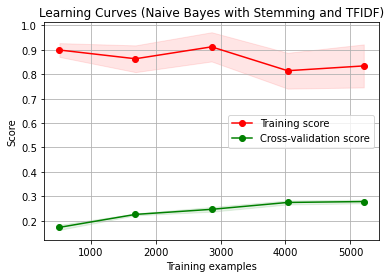

In [77]:
title = "Learning Curves (Naive Bayes with Stemming and TFIDF)"

plot_learning_curve(model13, title, X, y, cv=cross_validator)

## Peformance as a function of words

Do examples with more words (longer examples) get classified correctly more often?

In [16]:
prediction_table['words'] = prediction_table['line'].str.split(" ").str.len()
prediction_table['correct_prediction'] = (prediction_table['true character'] == prediction_table['predicted character']).astype('int64')

In [17]:
reg_model = smf.ols('prediction_table["correct_prediction"] ~ prediction_table["words"]', data=prediction_table).fit()

reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     prediction_table["correct_prediction"]   R-squared:                       0.021
Model:                                                OLS   Adj. R-squared:                  0.021
Method:                                     Least Squares   F-statistic:                     139.3
Date:                                    Fri, 08 Jan 2021   Prob (F-statistic):           7.80e-32
Time:                                            12:47:22   Log-Likelihood:                -4107.1
No. Observations:                                    6507   AIC:                             8218.
Df Residuals:                                        6505   BIC:                             8232.
Df Model:                                               1                                         
Covariance Type:                                nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.2495      0.007     34.410      0.000       0.235       0.264
prediction_table["words"]     0.0050      0.000     11.805      0.000       0.004       0.006
==============================================================================
Omnibus:                     5837.202   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1159.116
Skew:                           0.844   Prob(JB):                    2.00e-252
Kurtosis:                       1.807   Cond. No.                         22.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'accuracy')

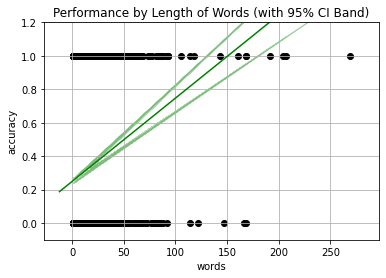

In [80]:
def abline(intercept, slope, col):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', color=col)
    

plt.scatter(x = prediction_table['words'].to_numpy(),
            y = prediction_table['correct_prediction'].to_numpy(),
            color='black')

abline(reg_model.params[0], reg_model.params[1], 'green')

conf_pred_intervals = reg_model.get_prediction(prediction_table['words']).summary_frame()

plt.fill_between(prediction_table['words'].to_numpy(), conf_pred_intervals['mean_ci_lower'], conf_pred_intervals['mean_ci_upper'], alpha=0.3, color='green')

plt.grid()
plt.ylim(-0.1,1.2)
plt.title('Performance vs. Length of Words (with 95% CI Band)')
plt.xlabel('words')
plt.ylabel('accuracy')

Using a t test and a confidence level of 95% ($\alpha=0.05$), we **reject** the null hypothesis that there is no relationship between the number of words in an example and our model's performance on it ($t=11.805$, $p<0.001$).

Having a longer line means that the change of a correct prediction increases.

## Export Model

In [81]:
model13.fit(X,y)
prod_model = model13.best_estimator_
dump(prod_model, './front_end/production_model.joblib')

prod_model

Pipeline(steps=[('vect', StemCountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf', MultinomialNB(alpha=0.01, fit_prior=False))])

## Character Correlations

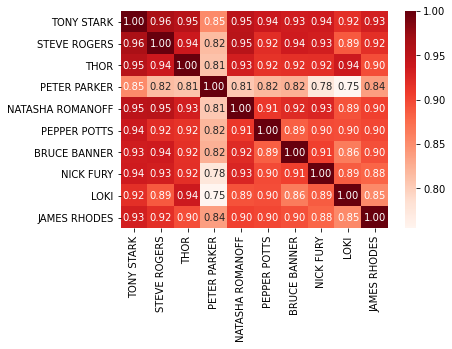

In [69]:
vect = prod_model.named_steps['vect']
main_characters = mcu_subset['character'].value_counts().index.to_numpy()

character_correlations = np.zeros(shape=(len(main_characters), len(main_characters)))

for i in range(0, len(main_characters)):
    for j in range(i, len(main_characters)):
        vector_i = np.sum(vect.transform(mcu_subset[mcu_subset['character'] == main_characters[i]]['line'].to_numpy()).toarray(), axis=0)
        vector_j = np.sum(vect.transform(mcu_subset[mcu_subset['character'] == main_characters[j]]['line'].to_numpy()).toarray(), axis=0)
            
        r = stats.stats.pearsonr(vector_i, vector_j)[0]
        character_correlations[i][j] = r
        character_correlations[j][i] = r

character_correlations = pd.DataFrame(character_correlations, columns=main_characters, index=main_characters)

dump(character_correlations, "./front_end/character_correlations.joblib")

sns.heatmap(character_correlations, annot=True, fmt='.2f', cmap=plt.cm.Reds)